In [1]:
import math
import numpy as np
import torch
import torchvision
import transformers

device = torch.device("cpu")

#image_processor = transformers.AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #lambda x: x / 255,
])


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision
model = torchvision.models.vgg19(pretrained=True).features
for param in model.parameters():
    param.requires_grad_(False)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/vnik/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548M/548M [01:20<00:00, 7.18MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

(255, 198)


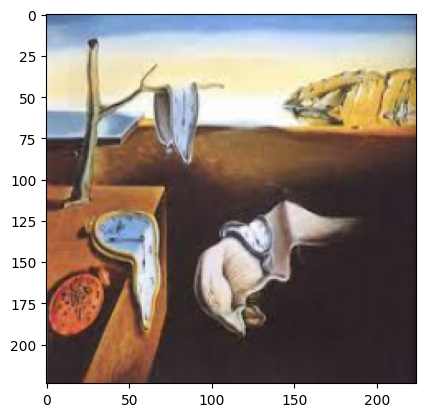

torch.Size([1, 3, 224, 224])
torch.Size([1, 512, 7, 7])


AttributeError: 'Tensor' object has no attribute 'hidden_states'

In [6]:
import matplotlib.pyplot as plt
import PIL

def content_loss(a, b):
    diff2 = (a - b) / 2
    diff2 = diff2 * diff2
    return torch.sum(diff2)

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram) / 2 / a.shape[1] / a.shape[2] / a.shape[3]
    diff2 = diff2 * diff2
    return torch.sum(diff2)

dog = PIL.Image.open('dog6.jpeg')
#print(np.asarray(dog))
time = PIL.Image.open('time2.jpeg')
#dog.show()
print(dog.size)

dog_inputs = image_processor(dog).unsqueeze(0).to(device)
#print(dog_inputs)
#print(torch.min(dog_inputs))
time_inputs = image_processor(time).unsqueeze(0).to(device)
plt.imshow(time_inputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.show()
print(dog_inputs.shape)
with torch.no_grad():
    dog_outputs = model(dog_inputs)
    time_outputs = model(time_inputs)
    print(dog_outputs.shape)

for dog_state, time_state in zip(dog_outputs.hidden_states, time_outputs.hidden_states):
    print(dog_state.shape)
    print(content_loss(dog_state, time_state))
    print(style_loss(dog_state, time_state))
    print("")    

In [ ]:
content_target = PIL.Image.open('dog.jpeg')
#style_target = PIL.Image.open('dog_sketch.jpeg')
style_target = PIL.Image.open('dog_sketch.jpeg')

img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)
print(img.shape)

with torch.no_grad():
    content_inputs = image_processor(content_target).unsqueeze(0).to(device)
    style_inputs = image_processor(style_target).unsqueeze(0).to(device)
    content_outputs = model(content_inputs, output_hidden_states = True)
    style_outputs = model(style_inputs, output_hidden_states = True)

optimiser = torch.optim.Adam([img], lr = 1e-2, eps = 1e-12)
for i in range(1000000):
    optimiser.zero_grad()
    img_outputs = model(img, output_hidden_states = True)
    loss = (
        #content_loss(img_outputs.hidden_states[0], content_outputs.hidden_states[0])+
        #content_loss(img_outputs.hidden_states[1], content_outputs.hidden_states[1])
        #content_loss(img_outputs.hidden_states[2], content_outputs.hidden_states[2])+
        #content_loss(img_outputs.hidden_states[3], content_outputs.hidden_states[3])+
        content_loss(img_outputs.hidden_states[4], content_outputs.hidden_states[4])
    ) / 1 + (
        style_loss(img_outputs.hidden_states[0], style_outputs.hidden_states[0])+
        style_loss(img_outputs.hidden_states[1], style_outputs.hidden_states[1])+
        style_loss(img_outputs.hidden_states[2], style_outputs.hidden_states[2])+
        style_loss(img_outputs.hidden_states[3], style_outputs.hidden_states[3])+
        style_loss(img_outputs.hidden_states[4], style_outputs.hidden_states[4])
    ) / 5 * 10000
    if i % 10000 == 0:
        print(loss.item())
        plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
    loss.backward()
    optimiser.step()

plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.show()

In [ ]:
content_target = PIL.Image.open('dog.jpeg')
#style_target = PIL.Image.open('dog_sketch.jpeg')
style_target = PIL.Image.open('time2.jpeg')

img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)
print(img.shape)

with torch.no_grad():
    content_inputs = image_processor(content_target).unsqueeze(0).to(device)
    style_inputs = image_processor(style_target).unsqueeze(0).to(device)
    content_outputs = model(content_inputs, output_hidden_states = True)
    style_outputs = model(style_inputs, output_hidden_states = True)

optimiser = torch.optim.Adam([img], lr = 1e-3, eps = 1e-12)
for i in range(1000000):
    optimiser.zero_grad()
    img_outputs = model(img, output_hidden_states = True)
    loss = (
        #content_loss(img_outputs.hidden_states[0], content_outputs.hidden_states[0])+
        #content_loss(img_outputs.hidden_states[1], content_outputs.hidden_states[1])
        #content_loss(img_outputs.hidden_states[2], content_outputs.hidden_states[2])+
        #content_loss(img_outputs.hidden_states[3], content_outputs.hidden_states[3])+
        content_loss(img_outputs.hidden_states[4], content_outputs.hidden_states[4])
    ) / 1 + (
        style_loss(img_outputs.hidden_states[0], style_outputs.hidden_states[0])+
        style_loss(img_outputs.hidden_states[1], style_outputs.hidden_states[1])+
        style_loss(img_outputs.hidden_states[2], style_outputs.hidden_states[2])+
        style_loss(img_outputs.hidden_states[3], style_outputs.hidden_states[3])+
        style_loss(img_outputs.hidden_states[4], style_outputs.hidden_states[4])
    ) / 5 * 10000
    if i % 10000 == 0:
        print(loss.item())
        plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.show()
    loss.backward()
    optimiser.step()

plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
plt.show()